In [1]:
#%matplotlib inline
#%matplotlib widget
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons
import os,time,subprocess,glob
from PIL import Image

## set the following appropriately
PH_PROG = "./cubicalripser"     ## executable for Mac/Linux
#PH_PROG = "CubicalRipser.exe"   ## executable for Windows
IMG_DIR = "./lena/"  ## dir containing images; they must be of the same dimension
volfile = "vol.npy"  ## the image files will be combined and saved in this numpy file
ph_out = "PH.npy"    ## the computed persistent homology will be saved in this numpy file

In [2]:
## 3D example
# load image files from a dir and stack into a 3D array of type float64
input_files = IMG_DIR+"*.jpg"
files = sorted([f for f in glob.glob(input_files)])
img = np.dstack([Image.open(f).convert('L') for f in files]).astype('f8')
print(img.shape, img.dtype, np.min(img),np.max(img))

(512, 512, 9) float64 0.0 255.0


In [4]:
# make binary and apply distance transform
def dt(img,radius=15):
    from scipy.ndimage.morphology import distance_transform_edt
    from skimage.filters import threshold_otsu
#    bw_img = (img >= rank.otsu(img, disk(radius)))
    bw_img = (img >= threshold_otsu(img))
    dt_img = distance_transform_edt(bw_img)
    return(dt_img)

In [5]:
# apply distance transform, if you want
#img = dt(img)

In [6]:
# compute PH with the python wrapper (takes time)
import cripser as cr
start = time.time()
pd_py = cr.computePH(img)
print ("elapsed_time:{} sec".format(time.time() - start))

elapsed_time:6.7728590965271 sec


In [7]:
# compute PH with the executable via shell (takes time)
np.save(volfile,img)
start = time.time()
result = subprocess.run(PH_PROG+' --output '+ph_out+' '+volfile, shell=True)
print(result)
print ("elapsed_time:{} sec".format(time.time() - start))
pd = np.load(ph_out)

CompletedProcess(args='CubicalRipser.exe --output PH.npy vol.npy', returncode=0)
elapsed_time:7.168220520019531 sec


In [8]:
# the both method should give the same results
np.array_equal(pd,pd_py)


True

In [9]:
# load computed PH
pd0 = pd[pd[:,0] == 0]  # H_0
pd1 = pd[pd[:,0] == 1]  # H_1
pd2 = pd[pd[:,0] == 2]  # H_2
print("#0-cycle {}, #1-cycle {}, #2-cycle {}".format(len(pd0),len(pd1),len(pd2)))
# each line contains (dim,birth,death,x,y,z)
print(pd0[:5])
print(pd1[:5])
print(pd2[:5])

#0-cycle 48836, #1-cycle 61957, #2-cycle 16699
[[  0.   0.   1.   0. 325.   6.]
 [  0.   0.   1. 511. 316.   1.]
 [  0.   0.   1. 317. 507.   7.]
 [  0.   0.   1.   5. 318.   8.]
 [  0.   0.   1.   4. 317.   7.]]
[[  1. 231. 239.  51. 219.   5.]
 [  1. 230. 234.  63. 328.   2.]
 [  1. 230. 231.  51. 217.   5.]
 [  1. 229. 230.  52. 289.   3.]
 [  1. 229. 230.  49. 256.   4.]]
[[  2. 254. 255. 373. 179.   4.]
 [  2. 241. 242.  46. 253.   4.]
 [  2. 241. 242.  50. 288.   3.]
 [  2. 241. 242.  53. 222.   5.]
 [  2. 241. 248. 391. 223.   6.]]


In [10]:
# compute the heatmap of cycles with specified birth-death properties
img = np.load(volfile)
mx,my,mz=img.shape
selected_cycle = np.zeros(img.shape)
h=3
min_life = 10
max_life =255
min_birth = 0
max_birth = 255
dimension = 2
pds = pd[pd[:,0] == dimension ]
pds = pds[min_life < pds[:,2]-pds[:,1]]
pds = pds[pds[:,2]-pds[:,1] < max_life]
pds = pds[min_birth < pds[:,1]]
pds = pds[pds[:,1] < max_birth]

print(pds.shape)
for c in pds:
    x,y,z=int(c[3]),int(c[4]),int(c[5])
#    selected_cycle[x,y,z] += 1
    selected_cycle[max(0,x-h):min(mx,x+h),max(0,y-h):min(my,y+h),max(0,z-h):min(mz,z+h)] += 1

print(np.min(selected_cycle),np.max(selected_cycle),np.sum(selected_cycle))

(3645, 6)
0.0 7.0 671592.0


<IPython.core.display.Javascript object>


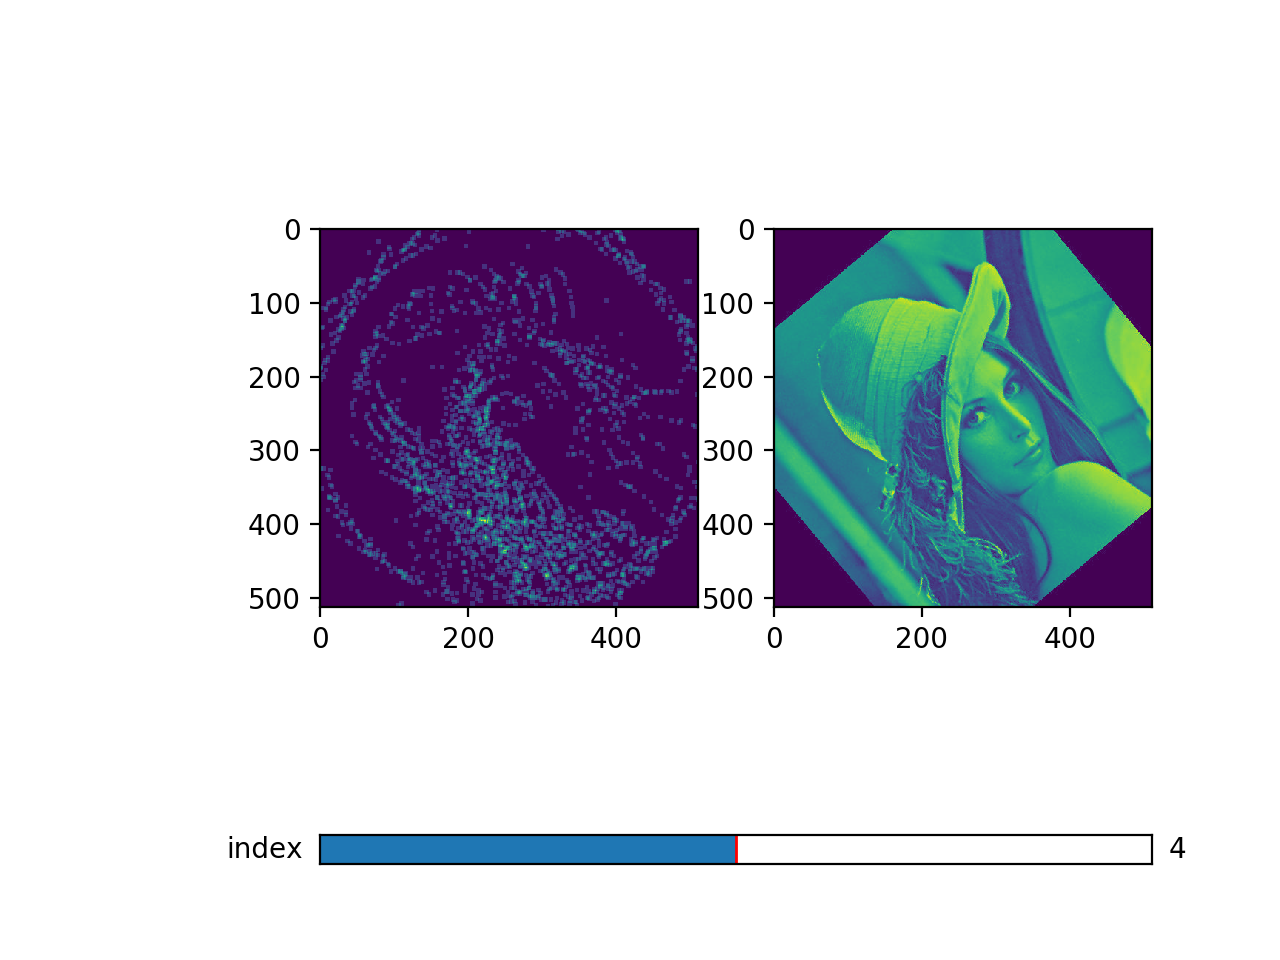

In [11]:
# Visualise the result
vol = selected_cycle
#vol = selected_cycle > 300
fig = plt.figure()
fig.subplots_adjust(left=0.25, bottom=0.25)
ax = plt.subplot(121)
ind = vol.shape[2]//2
l = ax.imshow(vol[:,:,ind])
ax = plt.subplot(122)
l2 = ax.imshow(img[:,:,ind])
def update(val):
    ind = int(slider.val)
    l.set_data(vol[:,:,ind])
    l2.set_data(img[:,:,ind])
    fig.canvas.draw()        
ax = fig.add_axes([0.25, 0.1, 0.65, 0.03])
slider = Slider(ax, 'index', 0, vol.shape[2] - 1, valinit=ind, valfmt='%i')
slider.on_changed(update)
plt.show()

In [2]:
## 2D example
input_file = IMG_DIR+"lena00.jpg"
img = np.array(Image.open(input_file).convert('L'),dtype='f8')
print(img.shape, img.dtype, np.min(img),np.max(img))

(512, 512) float64 14.0 248.0


In [3]:
# compute PH
import cripser as cr
start = time.time()
pd = cr.computePH(img)
print ("elapsed_time:{} sec".format(time.time() - start))
print(pd.shape)

elapsed_time:0.23886966705322266 sec
(19559, 6)
